In [37]:
# Load the relevant packages
import pandas as pd
import numpy as np
import math
import json
import re
import time
import sys
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import progressbar # pip install progressbar2 in terminal
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from datetime import datetime
import seaborn as sns
% matplotlib inline

Link https://medium.com/@patrick.ring/how-consumers-behave-on-the-starbucks-reward-app-udacity-project-4082575dc3fc

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [38]:
# We first define a function that converts a string into a dateime object. This funciton will be used later. 
def convert_to_datetime(elem):
    """Converts a string to a datetime object
    return datetime.strptime(str(elem), '%Y%m%d')

In [39]:
# First we look at and clean the portfolio data set.
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2



## Clean the offer portfolio data

    Change the name of the 'id' column to 'offerid'
    Change the name of the 'duration' column to 'durationdays'
    Change the name of the 'offer_type' column to 'offertype'
    One hot encode the 'offertype' column
    One hot encode the 'channels' columns
    Replace the 'offertype' and 'channels' columns with their respective one hot encoded values



In [40]:
# First, we choose a common labeling of the variables.
portfolio.rename(columns = {'duration':'durationdays', 'id': 'offerid', 'offer_type':'offertype'}, inplace = True)
# One hot encode the 'offertype' column
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['offertype'])], axis=1);
# One hot encode the 'channels' columns
ml_binarizerobj = MultiLabelBinarizer()
ml_binarizerobj.fit(portfolio['channels'])
channels_df =\
        pd.DataFrame(ml_binarizerobj.transform(portfolio['channels']),
columns=ml_binarizerobj.classes_)
# merge data-set
portfolio = pd.concat([portfolio,  channels_df], axis=1)

In [41]:
# Look at the new data-set
portfolio.head()

,channels,difficulty,durationdays,offerid,offertype,reward,bogo,discount,informational,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1


# 1. Question

What is the relation between offer difficulty and durationdays

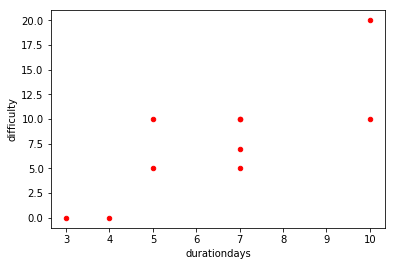

In [42]:
portfolio.plot(kind='scatter',x='durationdays',y='difficulty',color='red')
plt.show()

In [43]:
portfolio['durationdays'].corr(portfolio['difficulty'])

0.80841375882907474

# 1. Answer: Very high positive correlation

In [44]:
# Second, we look at and clean the customer profile data set.
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN



# Clean the customer profile data

    Remove customers with missing income data
    Remove customer profiles where the gender attribute is missing
    Change the name of the 'id' column to 'customerid'
    Transform the 'became_member_on' column to a datetime object
    One hot encode a customer's membership start year
    One hot encode a customer's age range
    Transform a customer's gender from a character to a number



In [45]:
# Remove customers with unspecified income
profile = profile[profile['income'].notnull()]
# Remove customers with unspecified gender
profile = profile[profile['gender'] != 'O']
# Change the name of the 'id' column to 'customerid'
profile.rename(columns = {'id':'customerid'}, inplace = True)
#Transform the 'became_member_on' column to a datetime object
profile = profile.reset_index(drop=True)
profile['became_member_on'] =\
profile['became_member_on'].apply(convert_to_datetime)
profile['membershipstartyear'] =\
        profile['became_member_on'].apply(lambda elem: elem.year)

membershipstartyear_df = pd.get_dummies(profile['membershipstartyear'])
binarizerobj = LabelBinarizer()
profile['gender'] = binarizerobj.fit_transform(profile['gender'])
min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

profile['agerange'] =\
    pd.cut(profile['age'],(range(min_age_limit,max_age_limit + 10, 10)),
right=False)
profile['agerange'] = profile['agerange'].astype('str')

agerange_df = pd.get_dummies(profile['agerange'])

In [46]:
# Merge data
profile = pd.concat([profile, membershipstartyear_df,agerange_df], axis=1)

In [47]:
# Look at the data
profile.head()

,age,became_member_on,gender,customerid,income,membershipstartyear,agerange,2013,2014,2015,...,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,"[50, 60)",0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,"[70, 80)",0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,"[60, 70)",0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,"[60, 70)",0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,"[50, 60)",0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [94]:
profile.describe()

,age,gender,income,membershipstartyear,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
count,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000
mean,54.393417,0.580579,65435.707931,2016.618696,0.018545,0.045028,0.107302,0.204749,0.377062,0.247314,0.014029,0.001095,0.092589,0.102854,0.155273,0.238486,0.202012,0.120235,0.056183,0.017245
std,17.400201,0.493481,21633.524110,1.199147,0.134916,0.207374,0.309507,0.403532,0.484667,0.431466,0.117613,0.033073,0.289865,0.303778,0.362177,0.426173,0.401515,0.325248,0.230282,0.130187
min,18.000000,0.000000,30000.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,0.000000,49000.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,1.000000,64000.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,66.000000,1.000000,80000.000000,2017.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,101.000000,1.000000,120000.000000,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [97]:
profile.groupby(['gender'], as_index=False).mean().groupby('gender')['age'].mean()

gender
0    57.54495
1    52.11669
Name: age, dtype: float64

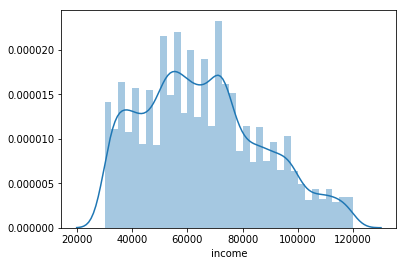

In [48]:
sns.distplot(profile["income"])

In [49]:
male_customers = profile[profile['gender'] == 1]
female_customers = profile[profile['gender'] == 0]


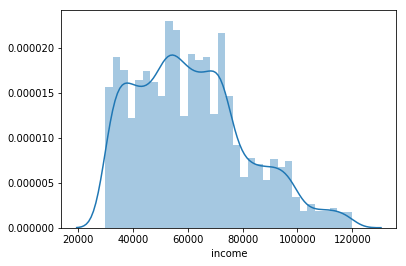

In [98]:
sns.distplot(male_customers["income"])
plt.savefig('male')

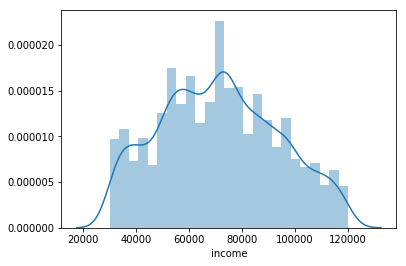

In [99]:
sns.distplot(female_customers["income"])
plt.savefig('female')

In [52]:
# We look at and clean the transcript data set.
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# Clean the transaction data

    Change the name of the 'person' column to 'customerid'
    Remove customer id's that are not in the customer profile DataFrame
    Convert time variable units from hours to days
    Change the name of the 'time' column to 'timedays'
    Create a DataFrame that describes offers
        Create an offerid column
        Parse the offer event type (i.e. 'received', 'viewed', or 'completed')
        One hot encode customer offer events
    Create a DataFrame that describes customer transaction events
        Parse customer transaction values



In [53]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [54]:
# Remove customer id's that are not in the customer profile DataFrame
transcript.rename(columns = {'person':'customerid'}, inplace = True)
# Remove customer id's that are not in the customer profile DataFrame
select_data = transcript['customerid'].isin(profile['customerid'])
transcript = transcript[select_data]
transcript.head(10)

,event,customerid,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
14,offer received,d53717f5400c4e84affdaeda9dd926b3,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15,offer received,f806632c011441378d4646567f357a21,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [55]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

In [56]:
transcript


,event,customerid,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
12,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
14,offer received,d53717f5400c4e84affdaeda9dd926b3,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
15,offer received,f806632c011441378d4646567f357a21,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN


In [57]:
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

In [58]:
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

In [59]:
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [60]:
transcript.head(20)

,event,customerid,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
12,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,3f207df678b143eea3cee63160fa8bed
14,offer received,d53717f5400c4e84affdaeda9dd926b3,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
15,offer received,f806632c011441378d4646567f357a21,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


In [61]:
percent_removed = 100 * (1 - select_data.sum() / select_data.shape[0])
print("Percentage of transactions removed: %.2f %%" % percent_removed)

Percentage of transactions removed: 12.31 %


In [62]:
#Convert from hours to days
transcript['time'] /= 24.0

In [63]:
pattern_obj = re.compile('^offer (?:received|viewed|completed)')

h_is_offer = lambda elem: pattern_obj.match(elem) != None

is_offer = transcript['event'].apply(h_is_offer)

offer_data = transcript[is_offer].copy()
offer_data = offer_data.reset_index(drop=True)
offer_data['offerid'] =\
offer_data['value'].apply(lambda elem: list(elem.values())[0])
pattern_obj = re.compile('^offer ([a-z]+$)')

h_transform = lambda elem: pattern_obj.match(elem).groups(1)[0]

offer_data['event'] = offer_data['event'].apply(h_transform)
event_df = pd.get_dummies(offer_data['event'])

In [64]:
 #Create a DataFrame that describes customer offer events
offer_data = pd.concat([offer_data, event_df], axis=1)
offer_data.drop(columns=['event', 'value'])

    # Select customer transaction events
transaction = transcript[is_offer == False]
transaction = transaction.reset_index(drop=True)

    # Transform customer transaction event values
transaction['amount'] =\
transaction['value'].apply(lambda elem: list(elem.values())[0])


    # Create a DataFrame that describes customer transactions
transaction = transaction.drop(columns=['event', 'value'])

In [65]:
offer_data=offer_data.drop(columns=['event', 'value'])

In [85]:

transaction.rename(columns={'time':'timedays'},inplace=True)
offer_data.rename(columns={'time':'timedays'},inplace=True)

In [86]:
profile.head()

,age,became_member_on,gender,customerid,income,membershipstartyear,agerange,2013,2014,2015,...,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,"[50, 60)",0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,"[70, 80)",0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,"[60, 70)",0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,"[60, 70)",0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,"[50, 60)",0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [87]:
def create_combined_records(customer_id,
                            portfolio,
                            profile,
                            offer_data,
                            transaction):
    """ 
    Creates a list of dictionaries that describes the effectiveness of
    offers to a specific customer
    INPUT:
        customer_id: String that refers to a specific customer
        profile: DataFrame that contains demographic data for each 
                 customer
                 
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
        offer_data: DataFrame that describes customer offer data
        transaction: DataFrame that describes customer transactions
    
    OUTPUT:
        rows: List of dictionaries that describes the effectiveness of
              offers to a specific customer
    """
    # Select a customer's profile
    cur_customer = profile[profile['customerid'] == customer_id]

    # Select offer data for a specific customer
    select_offer_data = offer_data['customerid'] == customer_id
    customer_offer_data = offer_data[select_offer_data]
    customer_offer_data = customer_offer_data.drop(columns='customerid')
    customer_offer_data = customer_offer_data.reset_index(drop=True)

    # Select transactions for a specific customer
    select_transaction = transaction['customerid'] == customer_id
    customer_transaction_data = transaction[select_transaction]

    customer_transaction_data =\
        customer_transaction_data.drop(columns='customerid')

    customer_transaction_data =\
        customer_transaction_data.reset_index(drop=True)

    # Initialize DataFrames that describe when a customer receives,
    # views, and completes an offer
    event_type = ['completed',
                  'received',
                  'viewed']

    offer_received =\
        customer_offer_data[customer_offer_data['received'] == 1]

    offer_received = offer_received.drop(columns=event_type)
    offer_received = offer_received.reset_index(drop=True)

    offer_viewed =\
        customer_offer_data[customer_offer_data['viewed'] == 1]

    offer_viewed = offer_viewed.drop(columns=event_type)
    offer_viewed = offer_viewed.reset_index(drop=True)

    offer_completed =\
        customer_offer_data[customer_offer_data['completed'] == 1]

    offer_completed = offer_completed.drop(columns=event_type)
    offer_completed = offer_completed.reset_index(drop=True)

    # Iterate over each offer a customer receives
    rows = []
    for idx in range(offer_received.shape[0]):

        # Initialize the current offer id
        cur_offer_id = offer_received.iloc[idx]['offerid']

        # Look-up a description of the current offer
        cur_offer = portfolio.loc[portfolio['offerid'] == cur_offer_id]
        durationdays = cur_offer['durationdays'].values[0]

        # Initialize the time period when an offer is valid
        cur_offer_startime = offer_received.iloc[idx]['timedays']

        cur_offer_endtime =\
            offer_received.iloc[idx]['timedays'] + durationdays

        # Initialize a boolean array that select customer transcations that
        # fall within the valid offer time window
        select_transaction =\
            np.logical_and(customer_transaction_data['timedays'] >=
                           cur_offer_startime,
                           customer_transaction_data['timedays'] <=
                           cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer completes an offer (this array may not contain any True
        # values)
        select_offer_completed =\
            np.logical_and(offer_completed['timedays'] >= cur_offer_startime,
                           offer_completed['timedays'] <= cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer views an offer (this array may not contain any True
        # values)
        select_offer_viewed =\
            np.logical_and(offer_viewed['timedays'] >= cur_offer_startime,
                           offer_viewed['timedays'] <= cur_offer_endtime)

        # Determine whether the current offer was successful
        cur_offer_successful =\
            select_offer_completed.sum() > 0 and select_offer_viewed.sum() > 0

        # Select customer transcations that occurred within the current offer
        # valid time window
        cur_offer_transactions = customer_transaction_data[select_transaction]

        # Initialize a dictionary that describes the current customer offer
        cur_row = {'offerid': cur_offer_id,
                   'customerid': customer_id,
                   'time': cur_offer_startime,
                   'offersuccessful': int(cur_offer_successful),
                   'totalamount': cur_offer_transactions['amount'].sum()}

        cur_row.update(cur_offer.iloc[0,1:].to_dict())

        cur_row.update(cur_customer.iloc[0,1:].to_dict())

        # Update a list of dictionaries that describes the effectiveness of 
        # offers to a specific customer
        rows.append(cur_row)

    return rows

In [105]:
profile.head()

,age,became_member_on,gender,customerid,income,membershipstartyear,agerange,2013,2014,2015,...,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,"[50, 60)",0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,"[70, 80)",0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,"[60, 70)",0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,"[60, 70)",0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,"[50, 60)",0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
clean_data = []
customerid_list = offer_data['customerid'].unique()

widgets=[' [',
             progressbar.Timer(), '] ',
             progressbar.Bar(),
             ' (',
             progressbar.ETA(),
             ') ']

for idx in progressbar.progressbar(range(len(customerid_list)),
                                       widgets=widgets):

    clean_data.extend(create_combined_records(customerid_list[idx],portfolio,profile,offer_data,transaction))

clean_data = pd.DataFrame(clean_data)

    # Initialize a list that describes the desired output DataFrame
    # column ordering
column_ordering = ['time', 'offerid', 'customerid', 'totalamount',
                       'offersuccessful', 'difficulty', 'durationdays',
                       'reward', 'bogo', 'discount', 'informational',
                       'email', 'mobile', 'social', 'web', 'gender', 
                       'income', 2013, 2014, 2015, 2016, 2017, 2018,
                       '[10, 20)', '[20, 30)', '[30, 40)', '[40, 50)',
                       '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)',
                       '[90, 100)', '[100, 110)']

clean_data = clean_data[column_ordering]

clean_data = clean_data.sort_values('time')


In [ ]:
clean_data.to_csv('clean.csv')

In [117]:
profile.head()

,age,became_member_on,gender,customerid,income,membershipstartyear,agerange,2013,2014,2015,...,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,"[50, 60)",0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,"[70, 80)",0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,"[60, 70)",0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,"[60, 70)",0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,"[50, 60)",0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [118]:
clean_data=clean_data.merge(profile, left_on='customerid', right_on='customerid')

In [119]:
list(clean_data.columns.values)

['Unnamed: 0',
 'time',
 'offerid',
 'customerid',
 'totalamount',
 'offersuccessful',
 'difficulty',
 'durationdays',
 'reward',
 'bogo',
 'discount',
 'informational',
 'email',
 'mobile',
 'social',
 'web',
 'gender_x',
 'income_x',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '[10, 20)_x',
 '[20, 30)_x',
 '[30, 40)_x',
 '[40, 50)_x',
 '[50, 60)_x',
 '[60, 70)_x',
 '[70, 80)_x',
 '[80, 90)_x',
 '[90, 100)_x',
 '[100, 110)_x',
 'age',
 'became_member_on',
 'gender_y',
 'income_y',
 'membershipstartyear',
 'agerange',
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 '[10, 20)_y',
 '[100, 110)_y',
 '[20, 30)_y',
 '[30, 40)_y',
 '[40, 50)_y',
 '[50, 60)_y',
 '[60, 70)_y',
 '[70, 80)_y',
 '[80, 90)_y',
 '[90, 100)_y']

In [125]:
# How do differnt consumers behave on the app?pr
X = clean_data[['income_y', 'gender_y', 'age']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = clean_data['totalamount']
from sklearn import linear_model

import statsmodels.api as sm

In [126]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            totalamount   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     7152.
Date:                Sun, 24 Mar 2019   Prob (F-statistic):               0.00
Time:                        19:44:29   Log-Likelihood:            -3.5802e+05
No. Observations:               65585   AIC:                         7.160e+05
Df Residuals:                   65582   BIC:                         7.161e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
income_y       0.0005   9.03e-06     53.374      0.0

In [127]:
# How do differnt consumers behave on the app?pr
X = clean_data[['reward', 'bogo', 'informational']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = clean_data['totalamount']

In [128]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            totalamount   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     4573.
Date:                Sun, 24 Mar 2019   Prob (F-statistic):               0.00
Time:                        19:49:54   Log-Likelihood:            -3.6107e+05
No. Observations:               65585   AIC:                         7.221e+05
Df Residuals:                   65582   BIC:                         7.222e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
reward            7.1179      0.090     79.387